# Datasets

Датасет 1 - успеваемость студентов [ссылка](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset)

В нем есть GPA и GradeClass, оба этих столбца это оценка, но GPA это вещественное значение, которое можно использовать для регрессии, а GradeClass можно использовать для классфикации.

Датасет 2 - спортзал [ссылка](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset)

gym

В них нет пропусков данных.

In [61]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [13]:
dataset1 = pd.read_csv("student_performance.csv")
dataset2 = pd.read_csv("gym_members.csv")

In [14]:
# Turn gender into int
dataset2['Gender'] = dataset2['Gender'].replace({'Female': '0', 'Male': '1'}).infer_objects(copy=False)

In [15]:
# One Hot Workout Type 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
dataset2 = encode_and_bind(dataset2, "Workout_Type")

In [16]:
# Classification dataset from dataset1
# Target is GradeClass
class_1 = dataset1.drop(columns=["Ethnicity", "StudentID", "GPA"])
X_class_1 = class_1.drop(["GradeClass"], axis=1)
y_class_1 = class_1["GradeClass"]

Xc1_train, Xc1_test, yc1_train, yc1_test = train_test_split(X_class_1, y_class_1, test_size=0.3)

In [17]:
# Classification dataset from dataset2
# Target is Gender
class_2 = dataset2.drop(columns=[])
X_class_2 = class_2.drop(["Gender"], axis=1)
y_class_2 = class_2["Gender"]

Xc2_train, Xc2_test, yc2_train, yc2_test = train_test_split(X_class_2, y_class_2, test_size=0.3)

# Classification

## Dataset 1 (Student Performance)

### Decision Tree (Overfit)

In [72]:
# Decision tree in sklearn is overfit by default as all leaves are pure
dtc1 = DecisionTreeClassifier()
dtc1.fit(Xc1_train, yc1_train);

In [73]:
print("Tree Accuracy", dtc1.score(Xc1_test, yc1_test))

Tree Accuracy 0.6337047353760445


### Decision Tree (Not Overfit)

In [74]:
dtc1 = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtc1.fit(Xc1_train, yc1_train);

In [75]:
print("Tree Accuracy", dtc1.score(Xc1_test, yc1_test))

Tree Accuracy 0.6894150417827298


### Default Random Forest

```
n_estimators=100,
criterion='gini',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
max_features='sqrt',
max_leaf_nodes=None,
```

In [76]:
rfc1_default = RandomForestClassifier()
rfc1_default.fit(Xc1_train, yc1_train);

In [77]:
print("Forest Accuracy", rfc1_default.score(Xc1_test, yc1_test))

Forest Accuracy 0.7186629526462396


In [78]:
rfc1_default_pred = rfc1_default.predict(Xc1_test)
print(classification_report(yc1_test, rfc1_default_pred))

              precision    recall  f1-score   support

         0.0       0.40      0.17      0.24        24
         1.0       0.50      0.44      0.47        80
         2.0       0.56      0.62      0.59       120
         3.0       0.62      0.46      0.53       139
         4.0       0.84      0.95      0.90       355

    accuracy                           0.72       718
   macro avg       0.58      0.53      0.54       718
weighted avg       0.70      0.72      0.70       718



In [79]:
# Importances should be labeled pandas series
def plot_mdi_importance(importance):
    importance = importance.sort_values(ascending=False)
    fig, ax = plt.subplots()
    importance.plot.barh(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

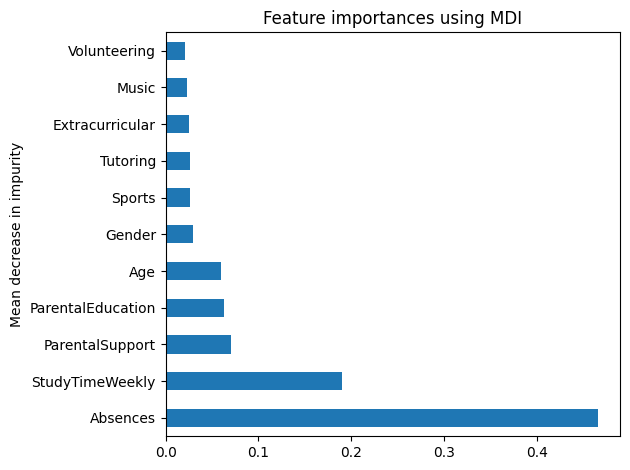

In [80]:
# Feature importance using mean decrease in impurity
rfc1_default_importances = pd.Series(rfc1_default.feature_importances_, index=Xc1_test.columns)
plot_mdi_importance(rfc1_default_importances)

### OOB Score Random Forest

In [81]:
# We have to enable out-of-bag score
# By default accuracy_score is used
rfc1_oob = RandomForestClassifier(
    oob_score=True,
)
rfc1_oob.fit(Xc1_train, yc1_train);

In [82]:
print("Forest OOB Score", rfc1_oob.oob_score_)

Forest OOB Score 0.7054958183990442


In [83]:
print("Forest Accuracy", rfc1_oob.score(Xc1_test, yc1_test))

Forest Accuracy 0.7172701949860725


In [84]:
rfc1_oob_pred = rfc1_oob.predict(Xc1_test)
print(classification_report(yc1_test, rfc1_oob_pred))

              precision    recall  f1-score   support

         0.0       0.45      0.21      0.29        24
         1.0       0.53      0.40      0.46        80
         2.0       0.53      0.64      0.58       120
         3.0       0.62      0.47      0.53       139
         4.0       0.84      0.95      0.89       355

    accuracy                           0.72       718
   macro avg       0.60      0.53      0.55       718
weighted avg       0.70      0.72      0.70       718



### Parameter tuning

In [91]:
def plot_score_features_subspace(feats, scores):
    fig, ax = plt.subplots()
    ax.plot(feats, scores)
    ax.set_xlabel("Features")
    ax.set_ylabel("Accuracy")
    fig.tight_layout()

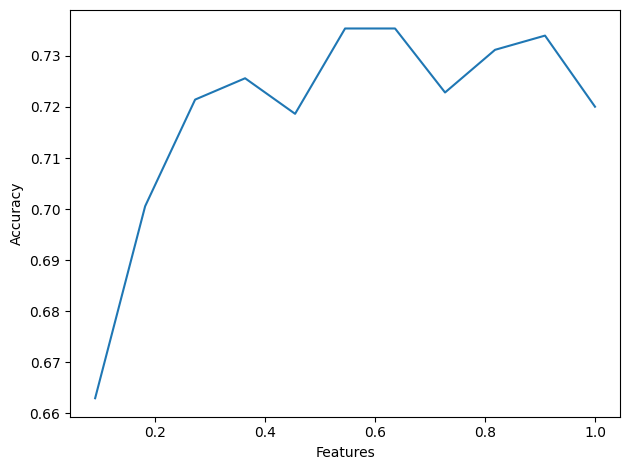

In [92]:
feats = []
scores = []
n = len(Xc1_train.columns)
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestClassifier(
        max_features=max_features,
    )
    rf.fit(Xc1_train, yc1_train)
    score = rf.score(Xc1_test, yc1_test)
    feats.append(max_features)
    scores.append(score)
plot_score_features_subspace(feats, scores)